In [1]:
## Exercise 7
# 1 Comment on your and other's solution to Exercise 6


In [2]:
# 2 Proof - Ridge Regression - Primal vs Dual (10 Points)
# First, in the primal formulation
# beta^ = (X.T * X + tau * I)^-1 * X.T * y
# Perfrom SVD on X, X = UAV.T, and X.T = VA.TU.T
# ### Then we can get (V*A.T*U.T*U*A*V.T + tau*I )^-1 * V*A.T*U.T 
# Second, In the dual formulation
# L(beta,e,a) = ||r||^2 + tau * ||beta||^2 + 2a.T(e - X.T*beta + y)
# Take the deviatives of beta and e
# beta = 1/tau * X.T * a
# e = -a
# Then reformualte the L(beta,e,a) = L(beta(a),e(a),a)
# and we solve the deviative of the new formula
# a_ =  tau * (X*X.T + tau*I)^-1 * y
# For the same problem beta^ = beta_
# beta_ = beta^ = 1/tau * X.T * a_ = X.T * (X*X.T + tau*I)^-1 * y = (X.T * X + tau * I)^-1 * X.T * y 
# given a^ = (X*X.T + tau*I)^-1 * y = 1/tau * a_
# Therefore, beta^ = X.T * a^


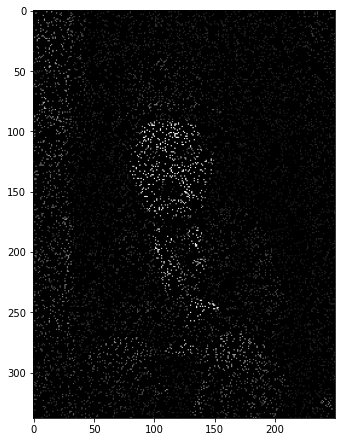

In [10]:
# 3 Kernelized (Ridge) Regression (10 Points)

import matplotlib.pyplot as plt
import numpy as np

from scipy.sparse.linalg import spsolve
# import cv2  # opencv

X = plt.imread("cc_90.png")
plt.figure(figsize=(10,7.5))
plt.gray()
plt.imshow(X)
plt.show()


In [14]:
class IKRR:
    def __init__(self, X):
        #print("Initialize ImageKRR ...")
        #print("Image size: ", X.shape)
        #print("Preparing training and test/missing data ... ")
        self.X = X
        C0, C1 = np.mgrid[0:X.shape[0], 0:X.shape[1]]
        self.X_train = np.stack((C0[ X != 0 ], C1[ X != 0 ])).T
        self.X_test = np.stack((C0[ X == 0 ], C1[ X == 0 ])).T
        self.Y_train = X[ X != 0 ]
        #print("Missing data: ", len(X[ X == 0 ]))
    def Kernel(self, X1, X2, s, thres, kernel):
        # Eud dis with multiple dimension array: 
        # https://stats.stackexchange.com/questions/362511/how-to-use-the-squared-exponential-kernel-with-multidimensional-vector-inputs
        if kernel == "exp":
            K = np.linalg.norm(X1[:,:,None] - X2.T, axis=1)
            K = np.exp( K / -2*s )
            if thres: 
                K[K <= thres] = 0 
        return K
    def train(self, s, tau, center, thres, kernel, method):
        X_train = self.X_train - self.X_train.mean(axis=0) if center else self.X_train 
        Y_train = self.Y_train - self.Y_train.mean() if center else self.Y_train
        if method == "Ridge":
            G = self.Kernel(X1=X_train, X2=X_train, s=s, thres=thres, kernel=kernel)
            G = G + ( np.ones(G.shape[0]) * tau ) if tau else G
            self.a = spsolve(A=G, b=Y_train)
            return self.a
        elif method == "NM":
            pass
    def predict(self, s, center, thres, kernel, method):
        X_train = self.X_train - self.X_train.mean(axis=0) if center else self.X_train
        X_test = self.X_test - self.X_test.mean(axis=0) if center else self.X_test
        Y_train = self.Y_train - self.Y_train.mean() if center else self.Y_train
        if method == "Ridge":
            k = self.Kernel(X1=X_test, X2=X_train, s=s, thres=thres, kernel=kernel)
            self.y_test = np.dot(k, self.a)
            #self.y_test = self.y_test  + self.Y_train.mean()
        elif method == "NM":
            pass
            #k = Kernel(X1=X_test, X2=X_train, s=s, thres=thres, kernel="exp")
            #np.dot(k, Y_train) 
        return self.y_test
    def Recon(self, plot):
        self.Xnew = self.X.copy()
        self.Xnew[self.X_test[:,0], self.X_test[:,1]] = self.y_test
        if plot:
            plt.figure(figsize=(10,7.5))
            plt.gray()
            plt.imshow(self.Xnew)
            plt.show()
        else:
            return self.Xnew


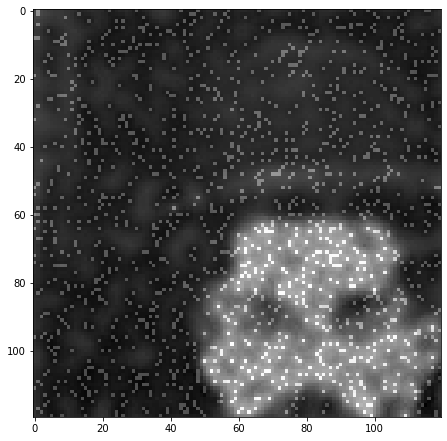

In [15]:
# Test IKRR

Xs = X[30:150,30:150]
ImgR = IKRR(Xs)
Ia = ImgR.train(s=1, tau=1, center=False, thres=0.1, kernel="exp", method="Ridge")
Iy = ImgR.predict(s=1, center=False, thres=0.1, kernel="exp", method = "Ridge")
ImgR.Recon(plot=True)


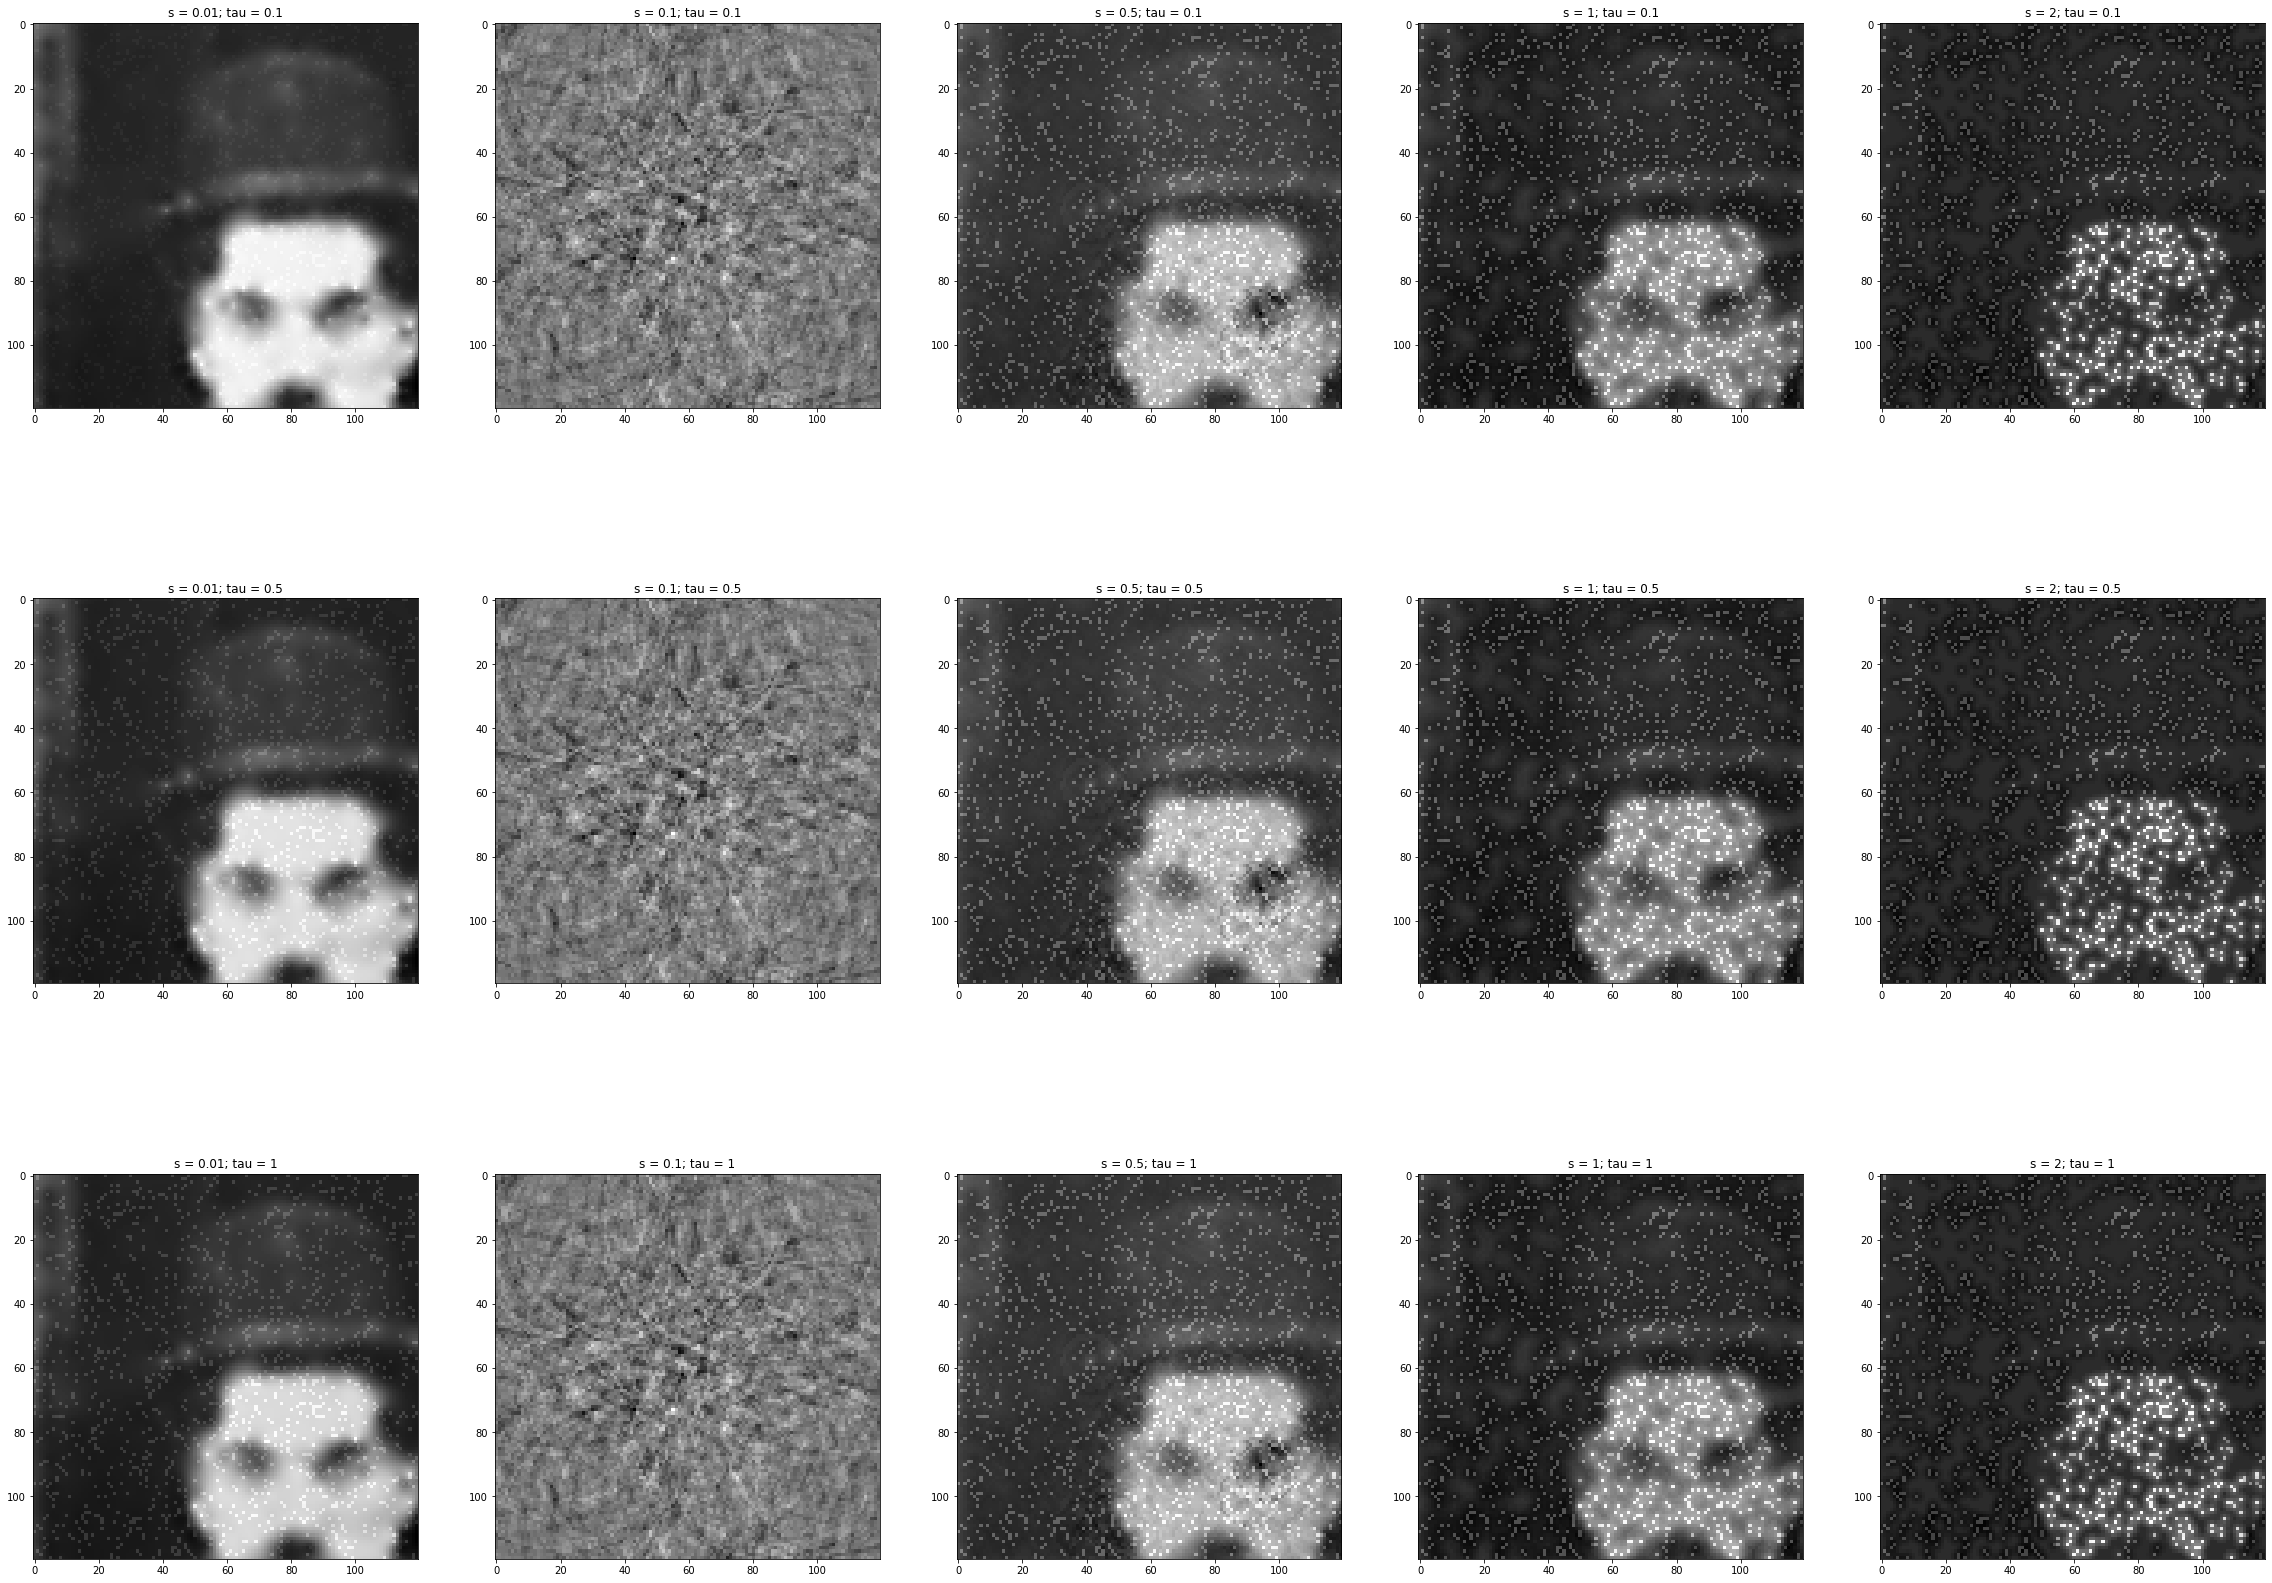

In [16]:
# Tune IKRR parameters

sL = [0.01,0.1,0.5,1,2]
tauL = [0.1,0.5,1]
x = 0
fig, ax = plt.subplots(len(tauL),len(sL), figsize=(40,30))
ax = ax.reshape(1,-1)

for j in range(len(tauL)):
    for i in range(len(sL)):
        ImgR = IKRR(Xs)
        Ia = ImgR.train(s=sL[i], tau=tauL[j], center=False, thres=0.1, kernel="exp", method="Ridge")
        Iy = ImgR.predict(s=sL[i], center=False, thres=0.1, kernel="exp", method = "Ridge")
        Ir = ImgR.Recon(plot=False)
        ax[0][x].imshow(Ir, cmap=plt.cm.gray)
        ax[0][x].set_title("s = "+ str(sL[i])+ "; tau = "+ str(tauL[j]))
        x += 1

plt.show()



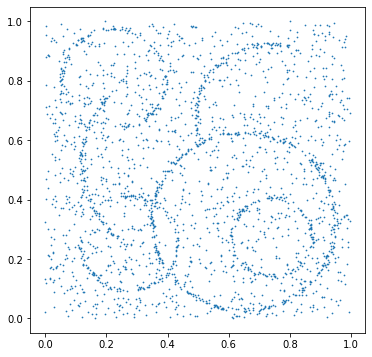

In [17]:
# 4 Fitting Circles

import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
data = np.load("circles.npy")
data.shape
plt.figure(figsize=(6,6))
plt.scatter(data[:,0], data[:,1], s=0.5)
plt.show()


In [20]:
# 4.1 RANSAC (6 Points)
# The RANSAC algorithm. 
# The number of iterations N (eq. (2)) depends on the lowest number of points m that uniquely define the model, the percentage of inliers w and the selected probability p .
# m = 3
# N = np.log(1-p) / np.log(1 - w**m)
# https://scipy-cookbook.readthedocs.io/items/Least_Squares_Circle.html
# http://www.dtcenter.org/sites/default/files/community-code/met/docs/write-ups/circle_fit.pdf

def calResidual(x, ci):
        # ci: xy center in a set of inliers
        # uc: updated center that should be used in optimize.least_squares("lm")
            ds = np.sqrt(np.sum(np.square(ci - x[None,:]), axis=1))
            return ds - ds.mean()

def calCircle(x,y, method):
    if method == "ransac":
        x0, x1, x2 = x[0], x[1], x[2]
        y0, y1, y2 = y[0], y[1], y[2]
        x12, x13, x31, x21 = x0 - x1, x0 - x2, x2 - x0, x1 - x0
        y12, y13, y31, y21 = y0 - y1, y0 - y2, y2 - y0, y1 - y0
        sx13, sy13= x0 ** 2 - x2 ** 2, y0 ** 2 - y2 ** 2 
        sx21, sy21 = x1 ** 2 - x0 ** 2, y1 ** 2 - y0 ** 2
        xc = (sx13 * y12 + sy13 * y12 + sx21 * y13 + sy21 * y13) / (2 * (x21 * y13 - x31 * y12 ))
        yc = (sx13 * x12 + sy13 * x12 + sx21 * x13 + sy21 * x13) / (2 * (y21 * x13 - y31 * x12))
        r = np.sqrt((x0 - xc)**2 + (y0-yc)**2)
    elif method == "ls" : 
        u = x - np.mean(x)
        v = y - np.mean(y)
        #    Suu * uc +  Suv * vc = (Suuu + Suvv) / 2
        #    Suv * uc +  Svv * vc = (Suuv + Svvv) / 2
        Suv, Suu, Svv  = sum(u*v), sum(u**2), sum(v**2)
        Suuv, Suvv, Suuu, Svvv = sum(u**2 * v), sum(u * v**2), sum(u**3), sum(v**3)
        # Solving the equation
        A = np.array([ [ Suu, Suv ], [Suv, Svv]])
        B = np.array([ Suuu + Suvv, Svvv + Suuv ]) / 2.0
        uc, vc = np.linalg.lstsq(A, B)[0]
        # Origin of circle
        xc, yc = np.mean(x) + uc, np.mean(y) + vc
        # Radius of circle
        r  = np.mean(np.sqrt((x-xc)**2 + (y-yc)**2))
    elif method == "lm":
        ci = np.vstack((x,y)).T
        co = (1,1)
        res = optimize.least_squares(calResidual, co, method='lm', kwargs={'ci': ci})
        xc, yc = res.x
        r = np.mean(np.sqrt(np.sum(np.square(ci - res.x[None,:]), axis=1)))
    return xc, yc, r

def fitCircle(data, e, N, method, C):
    d = data
    xc, yc, rc, dc = [], [], [], []
    if method == "ransac":
        print(" method == 'ransac' ")
        n = 0
        mi = []
        xmin, xmax = np.min(d[:,0]), np.max(d[:,0])
        ymin, ymax = np.min(d[:,1]), np.max(d[:,1])
        c = 1
        while (c <= C) & (len(d) >= 3) :
            xi, yi, ri, mi, n, di = 0, 0, 0, [], 0, []
            for _ in range(N):
                ind = np.random.choice( len(d), size = 3)
                x, y, r = calCircle(x=d[ind,0], y=d[ind,1], method="ransac")
                indi = np.abs( np.sqrt( (d[:,0] - x) ** 2 + (d[:,1] - y) ** 2 ) - r ) <= e 
                ni = len(d[indi, : ]) 
                if ni > n:
                    xi, yi, ri, mi, n, di = x.copy(), y.copy(), r.copy(), indi.copy(), ni, d[indi, : ].copy()
            if n == 0:
                break
            xc.append(xi)
            yc.append(yi)
            rc.append(ri)
            dc.append(di)
            d = d[~mi,:]
            c += 1    
    elif method == "ls":
        # input: a list of sets of inliers as input
        print(" method == 'ls' ")
        for i in range(len(d)):
            xmin, xmax = np.min(d[i][:,0]), np.max(d[i][:,0])
            ymin, ymax = np.min(d[i][:,1]), np.max(d[i][:,1])
            x, y, r = calCircle(x=d[i][:,0], y=d[i][:,1], method="ls")
            if (x>xmin) & (x<xmax) & (y>ymin) & (y<ymax):
                xi, yi, ri, di = x.copy(), y.copy(), r.copy(), d[i].copy()
                xc.append(xi)
                yc.append(yi)
                rc.append(ri)
                dc.append(di)
            else:
                continue
    elif method == "lm":
        for i in range(len(d)):
            ci = d[i]
            co = (1,1)
            xi, yi, ri = calCircle(x=ci[:,0], y=ci[:,1], method="lm")
            xc.append(xi.copy())
            yc.append(yi.copy())
            rc.append(ri.copy())
            dc.append(ci.copy())
    return xc, yc, rc, dc



 method == 'ransac' 
 method == 'ransac' 
 method == 'ransac' 
 method == 'ransac' 
 method == 'ransac' 
 method == 'ransac' 


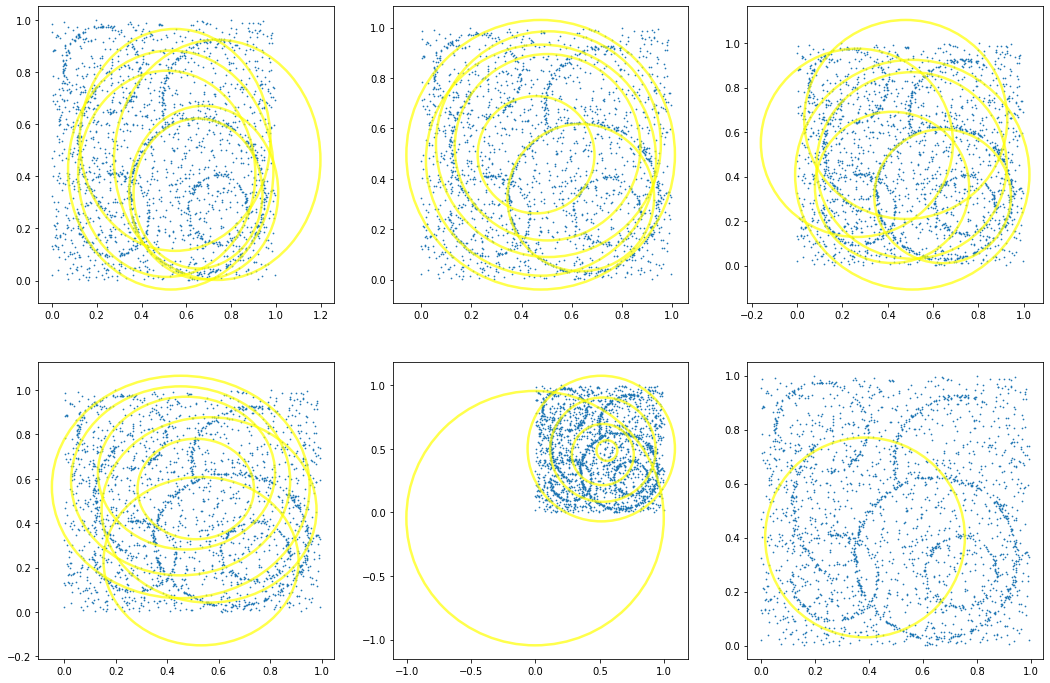

In [21]:
fig, ax = plt.subplots(2,3, figsize=(18,12))
ax = ax.reshape(1,-1)
elist = [0.01,0.02,0.03,0.05,0.1,0.5]

for e in range(len(elist)):
    xc, yc, rc, dc = fitCircle(data, e=elist[e], N=150, method="ransac", C = 6)
    #plt.figure(figsize=(6,6))
    ax[0][e].scatter(data[:,0], data[:,1], s=0.5)
    for i in range(len(rc)):
        circle = plt.Circle((xc[i], yc[i]), radius=rc[i], fill=False, alpha=0.7, linewidth=2.5, color='yellow') 
        ax[0][e].add_patch(circle)

plt.show()


 method == 'ransac' 


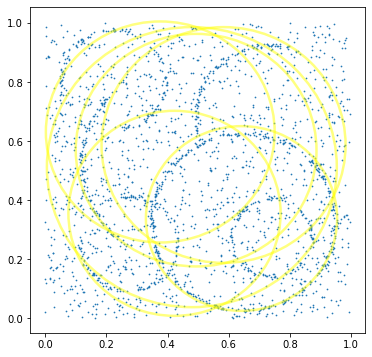

In [27]:
xc, yc, rc, dc = fitCircle(data, e=0.02, N=150, method="ransac", C = 6)
plt.figure(figsize=(6,6))
plt.scatter(data[:,0], data[:,1], s=0.5)

for i in range(len(rc)):
    circle = plt.Circle((xc[i], yc[i]), radius=rc[i], fill=False, alpha=0.5, linewidth=2.5, color='yellow') 
    plt.gca().add_patch(circle)

plt.show()


 method == 'ls' 


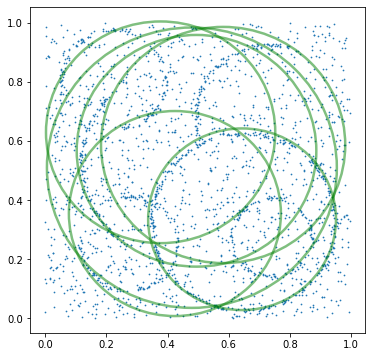

In [29]:
# 4.2 Algebraic Distance (4 Points)

xc_ls, yc_ls, rc_ls, dc_ls= fitCircle(dc, e=0.05, N=150, method="ls", C = 6)
plt.figure(figsize=(6,6))
plt.scatter(data[:,0], data[:,1], s=0.5)

for i in range(len(rc_ls)):
    circle = plt.Circle((xc_ls[i], yc_ls[i]), radius=rc_ls[i], fill=False, alpha=0.5, linewidth=2.5 , color='green') 
    plt.gca().add_patch(circle)

plt.show()



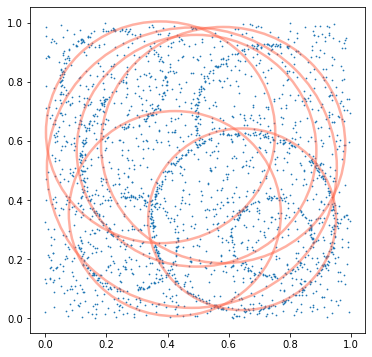

In [30]:
# 4.3 Levenberg-Marquardt (6 Points)

xc_lm, yc_lm, rc_lm, dc_lm= fitCircle(dc, e=0.05, N=150, method="lm", C = 6)
plt.figure(figsize=(6,6))
plt.scatter(data[:,0], data[:,1], s=0.5)

for i in range(len(rc_lm)):
    circle = plt.Circle((xc_lm[i], yc_lm[i]), radius=rc_lm[i], fill=False, alpha=0.5, linewidth=2.5, color='tomato') 
    plt.gca().add_patch(circle)

plt.show()


In [31]:
# 4.4 Comparison (4 Points)
# Pick one set of inliers, sample a subset of those and maybe add a couple of outliers.
# Here we pick the first set of inliers and sample half and then add couple of outliers from the second set

inliers = dc[0]
inliers = np.random.permutation(inliers)[:len(inliers)//2,:]
outliers = dc[1]
outliers = np.random.permutation(outliers)[:len(outliers)//10,:]
subdc = np.concatenate((inliers,outliers))


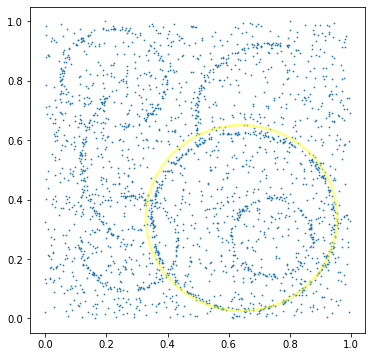

In [32]:
# Original

plt.figure(figsize=(6,6))
plt.scatter(data[:,0], data[:,1], s=0.5)

for i in range(len([subdc])):
    circle = plt.Circle((xc[i], yc[i]), radius=rc[i], fill=False, alpha=0.5, linewidth=2.5, color='yellow') 
    plt.gca().add_patch(circle)

plt.show()


 method == 'ls' 


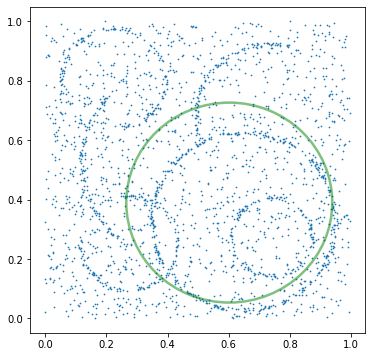

In [33]:
# Least square

xc_sub_ls, yc_sub_ls, rc_sub_ls, dc_sub_ls= fitCircle([subdc], e=0.03, N=150, method="ls", C = 6)
plt.figure(figsize=(6,6))
plt.scatter(data[:,0], data[:,1], s=0.5)

for i in range(len(rc_sub_ls)):
    circle = plt.Circle((xc_sub_ls[i], yc_sub_ls[i]), radius=rc_sub_ls[i], fill=False, alpha=0.5, linewidth=2.5 , color='green') 
    plt.gca().add_patch(circle)

plt.show()


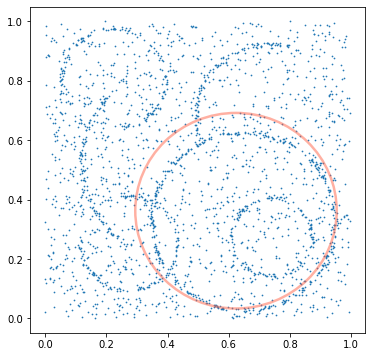

In [34]:
# LM

xc_sub_lm, yc_sub_lm, rc_sub_lm, dc_sub_lm= fitCircle([subdc], e=0.03, N=150, method="lm", C = 6)
plt.figure(figsize=(6,6))
plt.scatter(data[:,0], data[:,1], s=0.5)

for i in range(len(rc_sub_lm)):
    circle = plt.Circle((xc_sub_lm[i], yc_sub_lm[i]), radius=rc_sub_lm[i], fill=False, alpha=0.5, linewidth=2.5, color='tomato') 
    plt.gca().add_patch(circle)

plt.show()
